In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

dataset = pd.read_csv(r'C:\Users\Acer\Desktop\train.csv', header=0)
test_data = pd.read_csv(r'C:\Users\Acer\Desktop\test.csv', header=0)
prediction_data = pd.DataFrame({
    'id' : test_data['id'],
    'target' : 0.
})
dataset.head()

C:\Users\Acer\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [2]:
training_data = dataset.drop(['target','id'], axis=1)
training_label = dataset['target']
test_data = test_data.drop(['id'], axis=1)

training_data.shape, test_data.shape

((595212, 57), (892816, 57))

In [3]:
from collections import Counter
Counter(training_data.dtypes)

Counter({dtype('int64'): 47, dtype('float64'): 10})

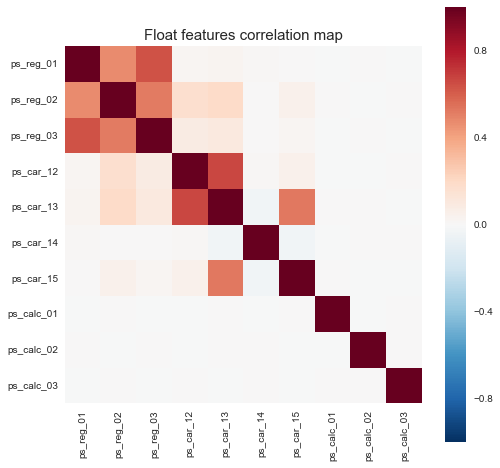

In [4]:
df_float = training_data.select_dtypes(include=["float"])
import seaborn as sns
corrmat = df_float.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Float features correlation map", fontsize=15)
plt.show()

In [5]:
from __future__ import division 
sum(training_data.isnull().any())
training_data.apply(lambda x: sum(x == -1) / len(x)).sort_values(ascending=False)

ps_car_03_cat     0.690898
ps_car_05_cat     0.447825
ps_reg_03         0.181065
ps_car_14         0.071605
ps_car_07_cat     0.019302
ps_ind_05_cat     0.009760
ps_car_09_cat     0.000956
ps_ind_02_cat     0.000363
ps_car_01_cat     0.000180
ps_ind_04_cat     0.000139
ps_car_02_cat     0.000008
ps_car_11         0.000008
ps_car_12         0.000002
ps_reg_02         0.000000
ps_calc_20_bin    0.000000
ps_ind_18_bin     0.000000
ps_reg_01         0.000000
ps_ind_15         0.000000
ps_ind_17_bin     0.000000
ps_ind_16_bin     0.000000
ps_ind_14         0.000000
ps_ind_13_bin     0.000000
ps_ind_12_bin     0.000000
ps_ind_11_bin     0.000000
ps_ind_10_bin     0.000000
ps_ind_09_bin     0.000000
ps_ind_08_bin     0.000000
ps_ind_07_bin     0.000000
ps_ind_06_bin     0.000000
ps_ind_03         0.000000
ps_car_04_cat     0.000000
ps_car_08_cat     0.000000
ps_car_06_cat     0.000000
ps_calc_08        0.000000
ps_calc_18_bin    0.000000
ps_calc_17_bin    0.000000
ps_calc_16_bin    0.000000
p

In [6]:
mean_cols = ["ps_reg_03", "ps_car_11", "ps_car_12", "ps_car_14"]
for col in mean_cols:
    training_data[col].replace(-1, np.mean(training_data[col]), inplace=True)
    test_data[col].replace(-1, np.mean(test_data[col]), inplace=True)

In [7]:
catgorical_cols = [i for i in training_data.columns if i.endswith("cat")]

In [8]:
def onehot_encode(df, cols):
    for col in cols:
        temp = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, temp], axis=1)
        df.drop(col, axis=1, inplace=True)

def gini(y_true, y_pred):
    actual = np.asarray(y_true)
    n = len(y_true)
    a_s = actual[np.argsort(y_pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n

def gini_normalized(y_true, y_pred):
    if y_pred.ndim == 2:
        y_pred = y_pred[:, 1]
    return gini(y_true, y_pred) / gini(y_true, y_true)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return [('gini', gini_score)]
#sklearn
#gini_sklearn = metrics.make_scorer(gini_normalized, True, True)

In [9]:
onehot_encode(training_data, catgorical_cols)
onehot_encode(test_data, catgorical_cols)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
params = {}
params['learning_rate'] = 0.1
params['n_estimators'] = 500
params['objective'] = 'binary:logistic'
params['silent'] = True
params['max_depth'] = 5
params['subsample'] = 0.8
params["gamma"] = 0.2
params['colsample_bytree'] = 0.85
params['colsample_bylevel'] = 0.9
params['min_child_weight'] = 1.3
kfold = 5
sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.20, random_state=0)

training_data = training_data.values
training_label = training_label.values
test_data = test_data.values

for i, (train_index, test_index) in enumerate(sss.split(training_data, training_label)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = training_data[train_index], training_data[test_index]
    y_train, y_valid = training_label[train_index], training_label[test_index]
    d_test = xgb.DMatrix(test_data)
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    model = xgb.train(params, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)
   
    print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
    p_test = model.predict(d_test)
    prediction_data['target'] += p_test/kfold

[Fold 1/5]
[0]	train-gini:0.201411	valid-gini:0.173065
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.36162	valid-gini:0.256636
[200]	train-gini:0.427127	valid-gini:0.253677
Stopping. Best iteration:
[133]	train-gini:0.383786	valid-gini:0.257021

[Fold 1/5 Prediciton:]
[Fold 2/5]
[0]	train-gini:0.19543	valid-gini:0.176411
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.36152	valid-gini:0.274674
Stopping. Best iteration:
[110]	train-gini:0.369432	valid-gini:0.27558

[Fold 2/5 Prediciton:]
[Fold 3/5]
[0]	train-gini:0.191679	valid-gini:0.177511
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-gini:0.361319	valid-gini:0.276073
Stopping. Best iteration:
[1

In [11]:
prediction_data.to_csv(r'C:\Users\Acer\Desktop' + r'\submission2.csv', index=True, index_label = 'id')

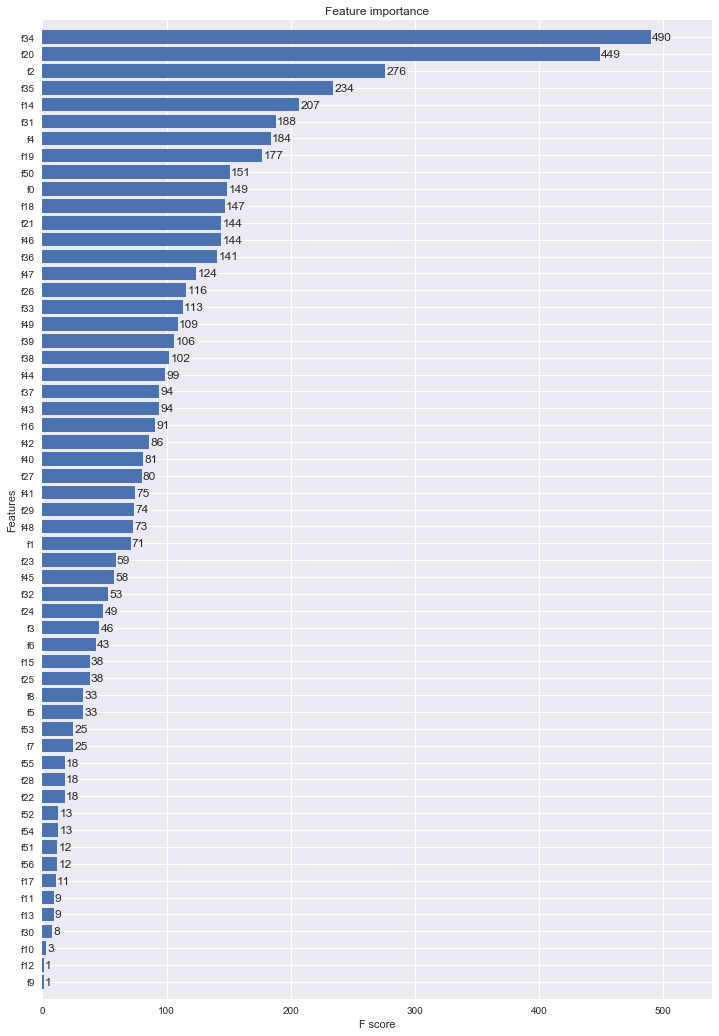

In [12]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()